In [8]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import os
import numpy as np
import wavemix.sisr as sisr
from PIL import Image
from torchinfo import summary
import cv2

In [2]:
BATCH_SIZE = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
data_path = Path.cwd() / "data"

train_data_folder = data_path/"DIV2K/DIV2K_train_LR_bicubic/X2"
test_data_folder = data_path/"DIV2K/DIV2K_valid_LR_bicubic/X2"

train_data_targest_folder = data_path/"DIV2K/DIV2K_train_HR"
test_data_targest_folder = data_path/"DIV2K/DIV2K_valid_HR"

In [12]:
class CustomDataSet(Dataset):
    def __init__(self, lr_image_folder, hr_image_folder, transform=None):
        self.lr_image_folder = Path(lr_image_folder)
        self.hr_image_folder = Path(hr_image_folder)
        self.lr_image_files = os.listdir(lr_image_folder)
        self.hr_image_files = os.listdir(hr_image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.lr_image_files)
    
    def __getitem__(self, idx):
        lr_image_path = self.lr_image_folder / self.lr_image_files[idx]
        hr_image_path = self.hr_image_folder / self.hr_image_files[idx]
        
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')
        
        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)
        
        return lr_image, hr_image

Number of training samples: 800


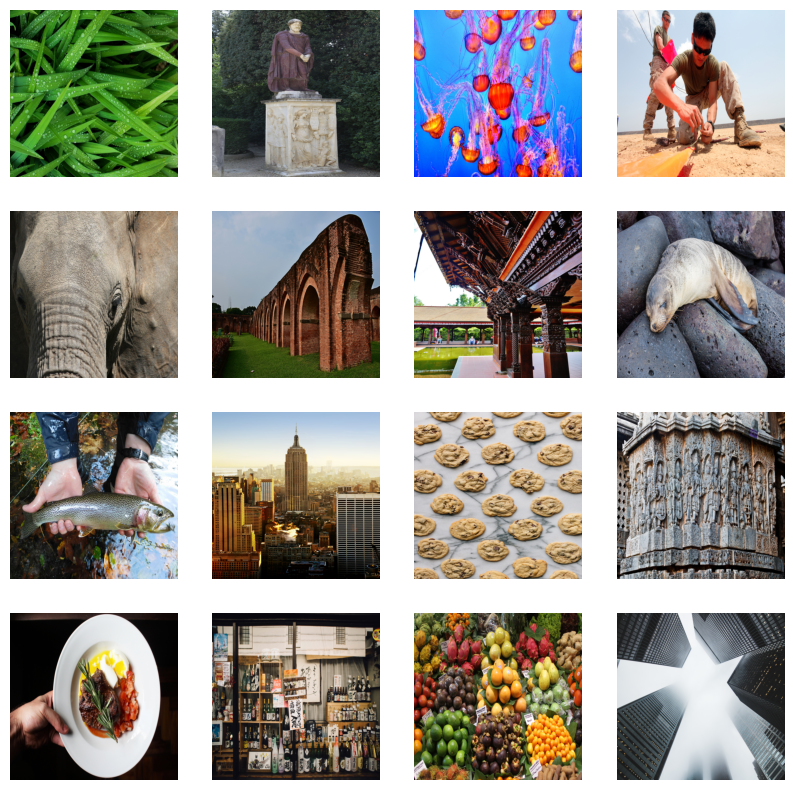

In [15]:
# Visualize random data
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((1000, 1000)),
    torchvision.transforms.ToTensor()
])

train_dataset = CustomDataSet(lr_image_folder=train_data_folder, 
                              hr_image_folder=train_data_targest_folder,
                                transform=transforms
                              )
test_dataset = CustomDataSet(lr_image_folder=test_data_folder,
                             hr_image_folder=test_data_targest_folder,
                                transform=transforms
                             )

# Plot random images
print(f"Number of training samples: {len(train_dataset)}")
random_indices = random.sample(range(len(train_dataset)), 16)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, idx in enumerate(random_indices):
    img = train_dataset[idx][0]
    ax = axs[i//4, i%4]
    ax.imshow(img.permute(1, 2, 0))
    ax.axis("off")
plt.show()

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class WaveMixSR(nn.Module):
    def __init__(
        self,
        *,
        depth,
        mult = 1,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.3,
        scale_factor = 2
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(sisr.Level1Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))
        
        self.final = nn.Sequential(
            nn.Conv2d(final_dim,int(final_dim/2), 3, stride=1, padding=1),
            nn.Conv2d(int(final_dim/2), 1, 1)
        )


        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners = False),
            nn.Conv2d(1, int(final_dim/2), 3, 1, 1),
            nn.Conv2d(int(final_dim/2), final_dim, 3, 1, 1)
        )

        self.path2 = nn.Sequential(
            nn.Upsample(scale_factor=int(scale_factor), mode='bilinear', align_corners = False),
        )

    def forward(self, img):

        y = img[:, 0:1, :, :] 
        crcb = img[:, 1:3, :, :]

        y = self.path1(y)


        for attn in self.layers:
            y = attn(y) + y

        y = self.final(y)

        crcb = self.path2(crcb)
        
        return  torch.cat((y,crcb), dim=1)



In [9]:
model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.3,
    scale_factor=2
)
model.to(DEVICE)
print(summary(model, input_size=(BATCH_SIZE, 3, 1000, 1000), verbose=0))


# image = next(iter(train_loader))[0].to(DEVICE)
# print(image.shape)

# output = model(image)
# print(output.shape)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 1, Upsample: 2, Conv2d: 2, Conv2d: 2, Conv2d: 3, Conv2d: 4, GELU: 4, Dropout: 4, Conv2d: 4, ConvTranspose2d: 4]

In [ ]:
def train(model:nn.Module,
          epochs:int,
          loss_fn:nn.Module,
          optimizer:torch.optim.Optimizer,
          train_loader:DataLoader,
          device:torch.device):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        for batch_idx, (lr_image, hr_image) in enumerate(train_loader):
            lr_image, hr_image = lr_image.to(device), hr_image.to(device)
            optimizer.zero_grad()
            output = model(lr_image)
            loss = loss_fn(output, hr_image)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f"Epoch: {epoch}, Batch index: {batch_idx}, Loss: {loss.item()}")
        torch.save(model.state_dict(), f"model_{epoch}.pth")

In [ ]:
train(model=model,
      epochs=10,
      loss_fn=nn.HuberLoss(),
      optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
      train_loader=train_loader,
      device=DEVICE)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.15 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 11.49 GiB is allocated by PyTorch, and 392.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)